# Case 2 Assignment

### Authors
- Katja (student.no.)
- Lukas (student no.)
- Mark (student no.)
- Sebastian (student no.)

### High level methodology

1. Phase-Specific Clustering:
- Why Separate Phases: By clustering each phase separately (pre-puzzle, puzzle, and post-puzzle), we can directly assess the impact of each experimental condition on physiological responses. This separation allows us to analyze how participants' responses evolve from a resting state to a stress-induced state and then to recovery.

- Execution: We will perform clustering on each phase's data independently, then track the cluster assignments of each participant across phases.

2. Comparing Clusters Across Phases: 

- Consistency Analysis: After clustering, the key analysis is to see whether participants who are grouped together in one phase remain together in subsequent phases. This would indicate consistency in physiological responses among those participants.

- Method: We could use contingency tables or cross-tabulations to compare cluster memberships. (or flow charts) For a more quantitative measure, metrics we will use  Adjusted Rand Index (ARI) which will help quantify the similarity between two clusterings.

3. Integration with Self-reported Emotional Scores:

- Purpose: Including emotional scores might provide additional insights into whether the physiological clustering correlates with participants' subjective experience of the tasks.

- Analysis: Correlate cluster membership with average scores of emotions like frustration, alertness, etc., to validate or explore the physiological findings.

## Imports

In [130]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

## Load Data

In [131]:
data = pd.read_csv("data/HR_data.csv")
data.head()

,Unnamed: 0,HR_TD_Mean,HR_TD_Median,HR_TD_std,HR_TD_Min,HR_TD_Max,HR_TD_AUC,HR_TD_Kurtosis,HR_TD_Skew,HR_TD_Slope_min,...,upset,hostile,alert,ashamed,inspired,nervous,attentive,afraid,active,determined
0,0,78.663878,76.70,7.480043,67.25,92.48,23048.450,-1.091448,0.369955,-0.7300,...,1.0,1.0,2.0,1.0,2.0,2.0,3.0,1.0,2.0,2.0
1,1,76.540732,76.61,2.584756,69.82,82.33,23959.920,-0.245338,0.338732,-0.3600,...,2.0,1.0,3.0,2.0,2.0,2.0,3.0,1.0,3.0,3.0
2,2,78.173563,77.92,2.681255,72.22,82.80,20324.605,-0.615922,-0.233047,-0.6300,...,1.0,1.0,2.0,1.0,3.0,2.0,3.0,2.0,3.0,3.0
3,3,83.073688,83.88,7.363598,69.42,96.12,24924.300,-0.866610,-0.046021,-0.4650,...,1.0,1.0,2.0,1.0,3.0,2.0,3.0,2.0,3.0,3.0
4,4,72.281250,72.91,3.193762,64.95,79.98,23052.100,0.200401,-0.560948,-0.3725,...,3.0,1.0,3.0,2.0,3.0,3.0,4.0,2.0,4.0,4.0


## Preprocessing

In [132]:
# Find the rows with missing values
missing = data.isnull().sum()
missing[missing > 0]

# Impute rows with missing values for the column EDA_TD_P_RT and EDA_TD_P_ReT, since there is only two of them
data["EDA_TD_P_RT"] = data["EDA_TD_P_RT"].fillna(data["EDA_TD_P_RT"].mean())
data["EDA_TD_P_ReT"] = data["EDA_TD_P_ReT"].fillna(data["EDA_TD_P_ReT"].mean())


# Drop first column
data = data.drop(columns=["Unnamed: 0"])

# Cast Round to int
data["Round"] = data["Round"].apply(lambda x: int(x.split("_")[1]))

# Cast Cohort to int
data["Cohort"] = data["Cohort"].apply(lambda x: int(x.split("_")[1]))

# Cast phase to int
data["Phase"] = data["Phase"].apply(lambda x: int(x.split("e")[1]))

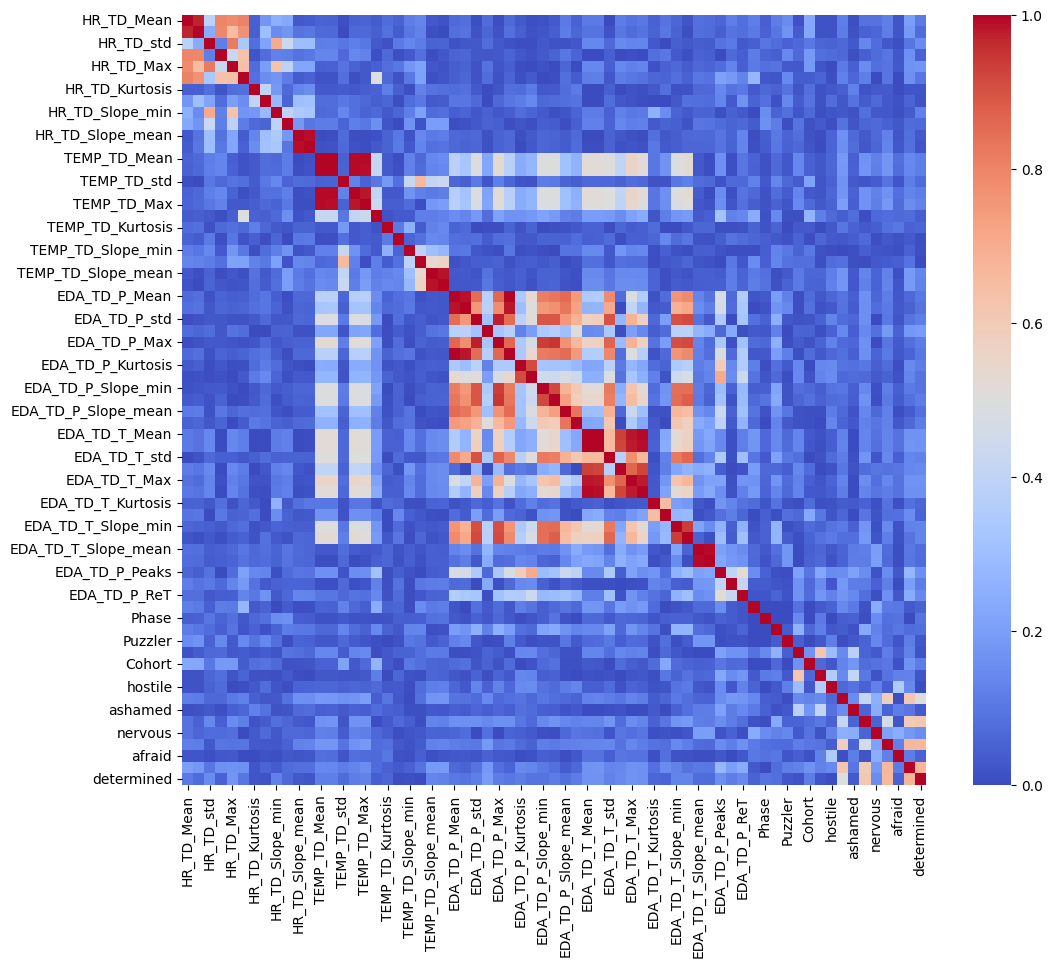

In [133]:
# Do correlation matrix and exclude highly correlated features
correlation = data.corr()
correlation = correlation.abs()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=False, cmap='coolwarm')
plt.show()


In [134]:
# Print correlation pairs that have a correlation higher than 0.9
correlation_pairs = correlation.unstack()
correlation_pairs = correlation_pairs[correlation_pairs > 0.9]
correlation_pairs = correlation_pairs[correlation_pairs < 1]
correlation_pairs = correlation_pairs.drop_duplicates()

for pair in correlation_pairs.index:
    print(pair, correlation_pairs[pair])

('HR_TD_Mean', 'HR_TD_Median') 0.9711090179326857
('HR_TD_Slope_mean', 'HR_TD_Slope') 0.988483580720514
('TEMP_TD_Mean', 'TEMP_TD_Median') 0.999642064136751
('TEMP_TD_Mean', 'TEMP_TD_Min') 0.9957182390665097
('TEMP_TD_Mean', 'TEMP_TD_Max') 0.9937968166938452
('TEMP_TD_Median', 'TEMP_TD_Min') 0.9950233585796113
('TEMP_TD_Median', 'TEMP_TD_Max') 0.9921187756697973
('TEMP_TD_Min', 'TEMP_TD_Max') 0.9823554279207789
('TEMP_TD_Slope_mean', 'TEMP_TD_Slope') 0.9862403216638368
('EDA_TD_P_Mean', 'EDA_TD_P_Median') 0.9849312638552072
('EDA_TD_P_Mean', 'EDA_TD_P_AUC') 0.9986950689710232
('EDA_TD_P_Median', 'EDA_TD_P_AUC') 0.9830782502328376
('EDA_TD_P_std', 'EDA_TD_P_Max') 0.9729404018401826
('EDA_TD_P_std', 'EDA_TD_T_Slope_min') 0.9033461816036368
('EDA_TD_P_std', 'EDA_TD_T_Slope_max') 0.915138069800837
('EDA_TD_P_Max', 'EDA_TD_P_Slope_min') 0.935288449231538
('EDA_TD_P_Max', 'EDA_TD_P_Slope_max') 0.9483760188161984
('EDA_TD_P_Max', 'EDA_TD_T_Slope_min') 0.9073653754199978
('EDA_TD_P_Max', 'EDA_

In [135]:
# Not including highly correlated features (e.g. mean and median) and only focusing on physiological features

features = ['HR_TD_Mean', 'HR_TD_std', 'HR_TD_Min', 'HR_TD_Max',
       'HR_TD_AUC', 'HR_TD_Kurtosis', 'HR_TD_Skew', 'HR_TD_Slope_min',
       'HR_TD_Slope_max', 'HR_TD_Slope', 'TEMP_TD_Mean',
       'TEMP_TD_std',
       'TEMP_TD_AUC', 'TEMP_TD_Kurtosis', 'TEMP_TD_Skew', 'TEMP_TD_Slope_min',
       'TEMP_TD_Slope_max', 'TEMP_TD_Slope',
       'EDA_TD_P_Mean', 'EDA_TD_P_std', 'EDA_TD_P_Min',
       'EDA_TD_P_Kurtosis', 'EDA_TD_P_Slope_max', 'EDA_TD_P_Slope_mean',
       'EDA_TD_P_Slope', 'EDA_TD_T_Mean', 'EDA_TD_T_std',
       'EDA_TD_T_Kurtosis',
       'EDA_TD_T_Skew',
       'EDA_TD_T_Slope', 'EDA_TD_P_Peaks',
       'EDA_TD_P_RT', 'EDA_TD_P_ReT'
]

In [136]:
X_phase1 = data[data["Phase"] == 1][features]
X_phase2 = data[data["Phase"] == 2][features]
X_phase3 = data[data["Phase"] == 3][features]

# Scale the data
scaler = StandardScaler()
X_phase1 = scaler.fit_transform(X_phase1)
X_phase2 = scaler.fit_transform(X_phase2)
X_phase3 = scaler.fit_transform(X_phase3)

# Cluster for phase 1
kmeans = KMeans(n_clusters=3, random_state=0).fit(X_phase1)
data.loc[data['Phase'] == 1, 'Cluster'] = kmeans.labels_


# Cluster for phase 2
kmeans = KMeans(n_clusters=3, random_state=0).fit(X_phase2)
data.loc[data['Phase'] == 2, 'Cluster'] = kmeans.labels_


# Cluster for phase 3
kmeans = KMeans(n_clusters=3, random_state=0).fit(X_phase3)
data.loc[data['Phase'] == 3, 'Cluster'] = kmeans.labels_

# TODO:
- [ ] Find the best number of clusters for each phase separately (using the elbow method, silhouette score, gap statistic)
- [ ] Use Rand index to compare the clustering results between the phases to check if participants are clustered similarly in all phases
- [ ] Use contingency tables or cross-tabulations to compare cluster memberships. (or flow charts) 

- [ ] Integration with Self-reported Emotional Scores:
- [ ] Analyse clusters with average scores of emotions like frustration, alertness, etc., to validate or explore the physiological findings.
- [ ] Analyse clusters with mean physiological features to understand the physiological differences between clusters